# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-rwc9ka1t
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-rwc9ka1t
     |████████████████████████████████| 6.6MB 6.6MB/s 
     |████████████████████████████████| 1.6MB 56.6MB/s 
     |████████████████████████████████| 245kB 53.0MB/s 
     |████████████████████████████████| 110.5MB 27kB/s 
     |████████████████████████████████| 307kB 54.7MB/s 
     |████████████████████████████████| 12.4MB 19.7MB/s 
     |████████████████████████████████| 256kB 39.4MB/s 
     |████████████████████████████████| 583kB 51.2MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-ggmoqlap/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-ggmoqlap/pyfolio
     |████████████████████████████████| 5.5MB 39.2MB/s 
     |████████████████████████████████| 1.0MB 44.4MB/s 
     |████████████████████████████████| 


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [2]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install git+https://github.com/quantopian/pyfolio


  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-1pn7gmdh
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-1pn7gmdh
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp36-none-any.whl size=75763 sha256=f17ee8610e51a5419e58465878b4489d9eee2a155cf75672c0893bb2ecb97c28
  Stored in directory: /tmp/pip-ephem-wheel-cache-vbebiir8/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
Successfully built pyfolio


<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2020-09-30'

In [7]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.shape

(88680, 7)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL
1,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT
4,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [10]:
df = FeatureEngineer(df.copy(),
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False).preprocess_data()

Successfully added technical indicators
Successfully added turbulence index


In [11]:
df.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0
5,2009-01-02,74.230003,77.300003,73.580002,48.043262,13695900.0,CVX,0.0,100.0,66.666667,100.0,0.0
6,2009-01-02,21.605234,22.060680,20.993229,14.527276,13251000.0,DD,0.0,100.0,66.666667,100.0,0.0
7,2009-01-02,22.760000,24.030001,22.500000,20.597496,9796600.0,DIS,0.0,100.0,66.666667,100.0,0.0
8,2009-01-02,84.019997,87.620003,82.190002,72.844467,14088500.0,GS,0.0,100.0,66.666667,100.0,0.0
9,2009-01-02,23.070000,24.190001,22.959999,17.909452,14902500.0,HD,0.0,100.0,66.666667,100.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [12]:
train = data_split(df, config.START_DATE,config.START_TRADE_DATE)
trade = data_split(df,config.START_TRADE_DATE,config.END_DATE)


In [13]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


In [14]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.249401,148158800.0,AAPL,-2.003499,37.867367,-91.588048,42.250808,119.879152
0,2019-01-02,93.910004,96.269997,93.769997,92.643311,4175400.0,AXP,-3.426008,41.204982,-97.742269,26.709417,119.879152
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200.0,BA,-5.550592,47.010000,-21.712382,13.611972,119.879152
0,2019-01-02,124.029999,127.879997,123.000000,119.302582,4783200.0,CAT,-0.686759,48.229089,-5.091209,0.873482,119.879152
0,2019-01-02,42.279999,43.200001,42.209999,40.382099,23833500.0,CSCO,-0.960061,44.872557,-87.496850,29.529377,119.879152


In [15]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension

In [16]:
env_setup = EnvSetup(stock_dim = stock_dimension,
                        state_space = state_space,
                        hmax = 100,
                        initial_amount = 1000000,
                        transaction_cost_pct = 0.001)

## Environment for Training



In [17]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)

## Environment for Trading



In [18]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade) 

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [20]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0002,
			  'verbose':0,
			  'timesteps':150000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



begin_total_asset:1000000
end_total_asset:3605996.6659141653
total_reward:2605996.6659141653
total_cost:  275734.00335139607
total_trades:  73865
Sharpe:  0.9626489853183927

begin_total_asset:1000000
end_total_asset:3552954.928867219
total_reward:2552954.928867219
total_cost:  266370.9790409698
total_trades:  73004
Sharpe:  1.0113200906121411
begin_total_asset:1000000
end_total_asset:3249548.8683646433
total_reward:2249548.8683646433
total_cost:  228222.72378727136
total_trades:  70391
Sharpe:  0.9242875407934459
begin_total_asset:1000000
end_total_asset:2357906.366346798
total_reward:1357906.36

### Model 2: DDPG

In [21]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
			               'verbose':0,
			               'timesteps':50000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

==============Model Training===========
Instructions for updating:
Use keras.layers.Dense instead.



begin_total_asset:1000000
end_total_asset:3278082.1198303066
total_reward:2278082.1198303066
total_cost:  5819.730338896489
total_trades:  44288
Sharpe:  0.8494046814688067
begin_total_asset:1000000
end_total_asset:2027424.3998158018
total_reward:1027424.3998158018
total_cost:  4821.581315910313
total_trades:  38000
Sharpe:  0.48003799402589176
begin_total_asset:1000000
end_total_asset:4232269.289113719
total_reward:3232269.289113719
total_cost:  8304.60447380157
total_trades:  43428
Sharpe:  0.8941766708519643
begin_total_asset:1000000
end_total_asset:3690192.8468325543
total_reward:2690192.8468325543
total_cost:  4046.801998721877
total_trades:  39950
Sharpe:  0.8438435030956893
begin_total_asset:1000000
end_total_asset:4121275.3982393397
total_reward:3121275.3982393397
total_cost:  3161.906084776384
total_trades:  36876
Sharpe:  0.8611544824126525
begin_total_asset:1000000
end_total

### Model 3: PPO

In [22]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'nminibatches': 4,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':50000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training===========


begin_total_asset:1000000
end_total_asset:2838573.3968208567
total_reward:1838573.3968208567
total_cost:  218263.94721130692
total_trades:  70857
Sharpe:  0.7700609467872713
begin_total_asset:1000000
end_total_asset:1781758.1034966
total_reward:781758.1034966
total_cost:  130041.10431636123
total_trades:  63827
Sharpe:  0.42855742541197034
begin_total_asset:1000000
end_total_asset:2581347.7973335646
total_reward:1581347.7973335646
total_cost:  151045.73955825897
total_trades:  65221
Sharpe:  0.6839921829742198
begin_total_asset:1000000
end_total_asset:2600138.902453165
total_reward:1600138.902453165
total_cost:  115326.74680110808
total_trades:  62008
Sharpe:  0.6568284530169676
begin_total_asset:1000000
end_total_asset:1687174.197910323
total_reward:687174.197910323
total_cost:  33861.52171485286
total_trades:  49349
Sharpe:  0.3808717208591959
begin_total_asset:1000000
end_total_asset:1816510.3698401607
total_reward:816510.3698401607
total_co

### Model 4: TD3

In [23]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':200000, 
                     'learning_rate': 0.0002,
			               'verbose':0,
			               'timesteps':50000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:3312144.639586015
total_reward:2312144.639586015
total_cost:  7380.206053174357
total_trades:  35584
Sharpe:  0.8997302567944108
begin_total_asset:1000000
end_total_asset:3731697.337407999
total_reward:2731697.337407999
total_cost:  1486.6642088949757
total_trades:  35613
Sharpe:  0.9372994261682959
begin_total_asset:1000000
end_total_asset:3757356.187222476
total_reward:2757356.187222476
total_cost:  1021.4222807239162
total_trades:  35244
Sharpe:  0.9316490753344869
begin_total_asset:1000000
end_total_asset:3773611.9563634805
total_reward:2773611.9563634805
total_cost:  998.9965967157827
total_trades:  40103
Sharpe:  0.9331672925145489
begin_total_asset:1000000
end_total_asset:3763397.262609715
total_reward:2763397.262609715
total_cost:  998.9982482680424
total_trades:  40103
Sharpe:  0.9320380910559253
begin_total_asset:1000000
end_total_asset:3769523.973160339
total_reward:2769523.973160339
total_cost

### Model 5: SAC

In [24]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)
agent = DRLAgent(env = env_train)
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
sac_params_tuning={
  'batch_size': 128,
 'buffer_size': 100000,
  'ent_coef':'auto_0.1',
 'learning_rate': 0.0001,
 'learning_starts':200,
 'timesteps': 50000,
 'verbose': 0}
model_sac = agent.train_SAC(model_name = "SAC_{}".format(now), model_params = sac_params_tuning)

==============Model Training===========

begin_total_asset:1000000
end_total_asset:2814374.1784732593
total_reward:1814374.1784732593
total_cost:  11754.782792834712
total_trades:  35149
Sharpe:  0.7362068793033862
begin_total_asset:1000000
end_total_asset:3122752.3474002834
total_reward:2122752.3474002834
total_cost:  2243.6827179108795
total_trades:  36911
Sharpe:  0.7187343715532327
begin_total_asset:1000000
end_total_asset:3472655.4282076377
total_reward:2472655.4282076377
total_cost:  4554.40219785966
total_trades:  39468
Sharpe:  0.7929664447726154
begin_total_asset:1000000
end_total_asset:3590727.831253359
total_reward:2590727.831253359
total_cost:  3603.040289494003
total_trades:  36305
Sharpe:  0.8029452622568944
begin_total_asset:1000000
end_total_asset:2787441.2371854694
total_reward:1787441.2371854694
total_cost:  3633.9273869667604
total_trades:  36208
Sharpe:  0.6876276591981112
begin_total_asset:1000000
end_total_asset:2861571.2779699615
total_reward:1861571.2779699615
t

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be the 99% quantile of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [25]:
data_turbulence = df[(df.date<'2019-01-01') & (df.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [26]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.936148
std        38.178006
min         0.000000
25%        58.034388
50%        74.015104
75%        96.948879
max       230.256690
Name: turbulence, dtype: float64

In [27]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [28]:
turbulence_threshold

230.25669016833135

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [29]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade) 

In [30]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade,
                                         turbulence_threshold=250) 

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_sac,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

previous_total_asset:1000000
end_total_asset:1217510.7237775829
total_reward:217510.72377758287
total_cost:  15509.552676920432
total trades:  7089
Sharpe:  0.6710092534418319


In [31]:
df_account_value.shape

(440, 2)

In [32]:
df_account_value.head()

,date,account_value
0,2019-01-02,1.000000e+06
1,2019-01-03,9.961629e+05
2,2019-01-04,1.007119e+06
3,2019-01-07,1.009500e+06
4,2019-01-08,1.012914e+06


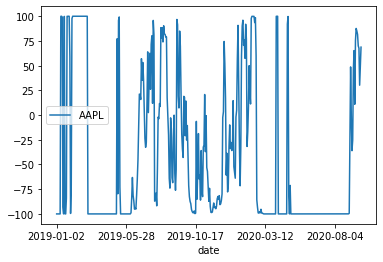

In [37]:
df_actions[['AAPL']].plot()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [33]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  14.165174982511264
sharpe ratio:  0.6710092534418319
Annual return          0.119316
Cumulative returns     0.217511
Annual volatility      0.197480
Sharpe ratio           0.671009
Calmar ratio           0.575472
Stability              0.581574
Max drawdown          -0.207335
Omega ratio            1.141713
Sortino ratio          0.935084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.798236
Daily value at risk   -0.024354
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  14.165174982511264
sharpe ratio:  0.6710092534418319
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,11.96%
Cumulative returns,21.751%
Annual volatility,19.748%
Sharpe ratio,0.67
Calmar ratio,0.58
Stability,0.58
Max drawdown,-20.734%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.73,2020-02-19,2020-03-12,2020-06-05,78
1,10.37,2020-06-08,2020-06-26,2020-09-02,63
2,7.45,2020-09-02,2020-09-23,NaT,NaN
3,5.96,2019-07-26,2019-08-05,2019-11-07,75
4,5.87,2019-04-08,2019-06-03,2019-06-20,54


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


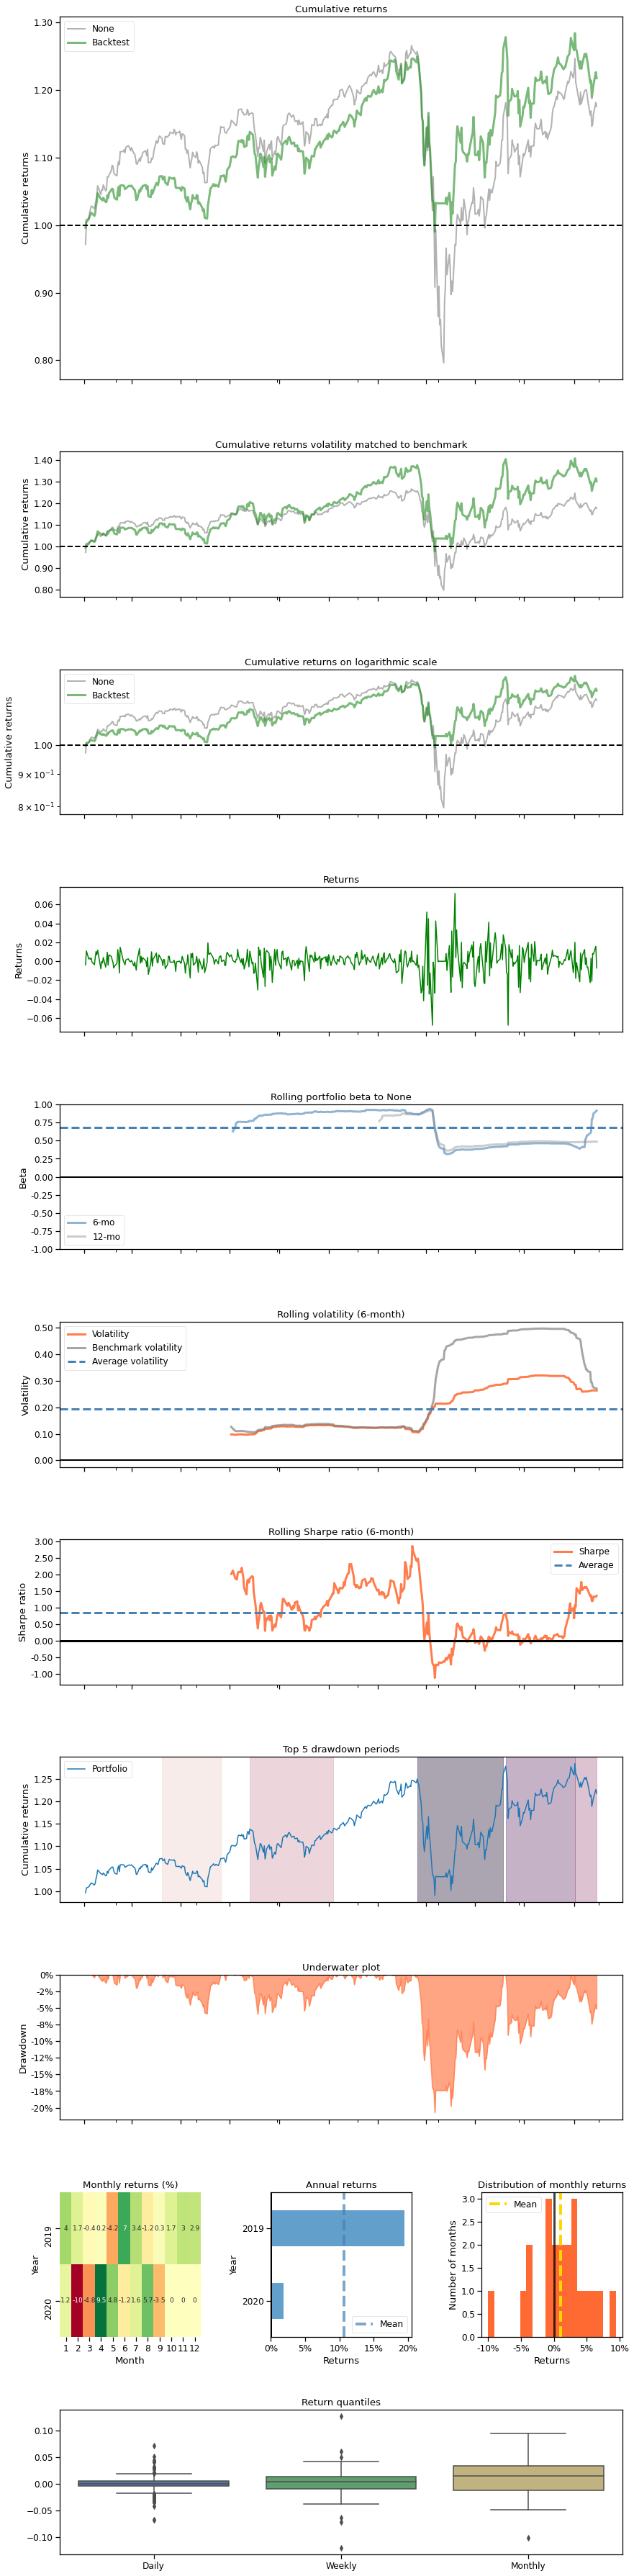

In [34]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-09-30')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [35]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2020-09-30')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)
Annual return          0.097239
Cumulative returns     0.175892
Annual volatility      0.287173
Sharpe ratio           0.468543
Calmar ratio           0.262198
Stability              0.010261
Max drawdown          -0.370862
Omega ratio            1.110729
Sortino ratio          0.641939
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.807113
Daily value at risk   -0.035647
Alpha                  0.000000
Beta                   1.000000
dtype: float64
